In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

Признаки одной заявки, которые есть в файлах X_train и X_test:

age — возраст заемщика

monthly_income — месячный доход заемщика

credit_card_utilization — отношение баланса на счету к лимиту по кредиту

debt_to_income — Соотношение долга к доходу

credits_loans — текущее число займов и кредитных линий

mortgage_loans — текущее количество ипотечных займов

family_members — количество членов в семье заемщика

overdue_30_59_days — число предыдущих просрочек выплат по кредиту от 30 до 59 дней

overdue_60_89_days — число предыдущих просрочек выплат по кредиту от 60 до 89 дней

overdue__more_than_90_days — число предыдущих просрочек выплат по кредиту более 90 дней

target — была ли просрочки выплат по кредиту более 90 дней - имеется только в обучающей выборке В файле y_train находятся ответы, была или нет просрочка (0 или 1) по факту

In [2]:
x_train = pd.read_csv('Downloads\cmf-2022-bank-scoring-case\X_train.csv')
x_test = pd.read_csv('Downloads\cmf-2022-bank-scoring-case\X_test.csv')
y_sample = pd.read_csv('Downloads\cmf-2022-bank-scoring-case\y_test_sample.csv')
y_train = pd.read_csv('Downloads\cmf-2022-bank-scoring-case\y_train.csv')

### Подготовка данных и очищение от выбросов

In [3]:
df = pd.concat([x_train, y_train], axis = 1)
df.drop(df[(df.age < 21) | (df.age > 70)].index, inplace = True)
df.drop(df[df.monthly_income > 300000].index, inplace = True)
df.drop(df[df.family_members >= 5].index, inplace = True)
df.drop(df[df.credits_loans > 30].index, inplace = True)
df.drop(df[df.mortgage_loans > 10].index, inplace = True)
df.drop(df[df.credit_card_utilization > 1000].index, inplace = True)
df.drop(df[df.debt_to_income > 10000].index, inplace = True)
df.drop(df[(df.overdue_30_59_days > 20)].index, inplace = True)
df.drop(df[(df.overdue_60_89_days > 20) ].index, inplace = True)
df.drop(df[(df.overdue__more_than_90_days > 20)].index, inplace = True)
y = df.target
x_train = df.drop(['target'], axis = 1)

In [4]:
indexes = x_test['index']
x_test.drop(['index'], inplace = True, axis = 1)
x_train['Test'] = 0
x_test['Test'] = 1
data = pd.concat([x_train, x_test])
data.head()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,Test
1,0.170659,45,1,2.405860,356.580765,5,0,0,0,0.0,0
3,0.046219,50,0,0.814508,2894.368968,12,0,1,0,3.0,0
4,0.679556,58,0,0.390311,24833.227614,15,0,4,0,2.0,0
5,0.874546,32,0,0.000000,3898.183106,0,0,0,0,3.0,0
6,0.525989,69,2,0.170485,8116.592035,8,0,1,1,0.0,0


In [5]:
data.monthly_income = data.monthly_income.fillna(data.monthly_income.mean())
data.family_members = data.family_members.fillna(data.family_members.mean())

In [6]:
train = data[data.Test == 0]
test = data[data.Test == 1]

In [7]:
x = train.copy()

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
scaled_features = scaler.transform(x)
scaled_data = pd.DataFrame(scaled_features, columns = x.columns)
x = scaled_data
test = scaler.transform(test)

In [9]:
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x, y, test_size = 0.1)

In [10]:
#создание пустых массивов для сбора данных по точности различных моделей
models = []
clas_models = []
f1_scores = []
auc_scores = []
rauc_scores = []
precisions = []
recalls = []
log_losses = []

## Самая основная модель - предсказание с помощью градиентного бустинга

In [11]:
models.append('Gradient Boosting')
gbr_params = {'n_estimators': 70,
          'max_depth': 3,
          'min_samples_split': 7,
          'learning_rate': 0.1,
          'loss': 'ls'
             }
gbr = GradientBoostingRegressor(**gbr_params)
gbr.fit(x_training_data, y_training_data)
preds = gbr.predict(x_test_data)
print("Model Accuracy: %.3f" % gbr.score(x_test_data, y_test_data))
mse = mean_squared_error(y_test_data, preds)
print('mse: %.3f' % mse)
log_losses.append(log_loss(y_test_data, preds))
print('log_loss: %.3f' % log_loss(y_test_data, preds))

auc_scores.append(roc_auc_score(y_test_data, preds))
print('Roc-Auc score:', roc_auc_score(y_test_data, preds))
df = pd.DataFrame()
df['index'] = y_sample['index']
df['target'] = gbr.predict(test)
df

Model Accuracy: 0.183
mse: 0.054
log_loss: 0.196
Roc-Auc score: 0.8371328382861521


,index,target
0,143522,0.000979
1,116747,-0.000623
2,66075,0.106328
3,133292,0.021172
4,83134,0.006580
...,...,...
38871,44475,0.075616
38872,103189,0.015053
38873,48732,0.018835
38874,135410,0.069662


In [12]:
# вариант с большим ROC-AUC, но большим log loss
gbr_params = {'n_estimators': 120,
          'max_depth': 4,
          'min_samples_split': 2,
          'learning_rate': 0.1,
          'loss': 'ls'
             }
gbr = GradientBoostingRegressor(**gbr_params)
gbr.fit(x_training_data, y_training_data)
preds = gbr.predict(x_test_data)
print("Model Accuracy: %.3f" % gbr.score(x_test_data, y_test_data))
mse = mean_squared_error(y_test_data, preds)
print('mse: %.3f' % mse)
print('log_loss: %.3f' % log_loss(y_test_data, preds))
print('Roc-Auc score:', roc_auc_score(y_test_data, preds))
df = pd.DataFrame()
df['index'] = y_sample['index']
df['target'] = gbr.predict(test)
df

Model Accuracy: 0.195
mse: 0.051
log_loss: 0.187
Roc-Auc score: 0.8590909241701121


,index,target
0,143522,-0.001305
1,116747,-0.000750
2,66075,0.113459
3,133292,0.019282
4,83134,0.005844
...,...,...
38871,44475,0.074002
38872,103189,0.012286
38873,48732,0.014100
38874,135410,0.063616


In [19]:
df['target'] = (df.target > 0.5 ) * 1
df

,index,target
0,143522,0
1,116747,0
2,66075,0
3,133292,0
4,83134,0
...,...,...
38871,44475,0
38872,103189,0
38873,48732,0
38874,135410,0


### Нахождение оптимального n_estimators

50 log_loss 0.18466659209233605
Roc-Auc score: 0.8570157774765208
------------------------------------
60 log_loss 0.1843835113694985
Roc-Auc score: 0.8577041430926242
------------------------------------
70 log_loss 0.18431219201486226
Roc-Auc score: 0.8580637909538513
------------------------------------
80 log_loss 0.18730439412438885
Roc-Auc score: 0.8581191138885542
------------------------------------
90 log_loss 0.18726944407495702
Roc-Auc score: 0.8581408722914448
------------------------------------
100 log_loss 0.18711993951463057
Roc-Auc score: 0.8586033603170053
------------------------------------
110 log_loss 0.18707188605418232
Roc-Auc score: 0.8588515817383188
------------------------------------
120 log_loss 0.1869414949376425
Roc-Auc score: 0.8592566002602813
------------------------------------
min log_loss = 0.18431219201486226 and it is with n_estimators  = 70
max ROC-AUC = 0.8592566002602813 and it is with n_estimators  = 120
------------------------------------


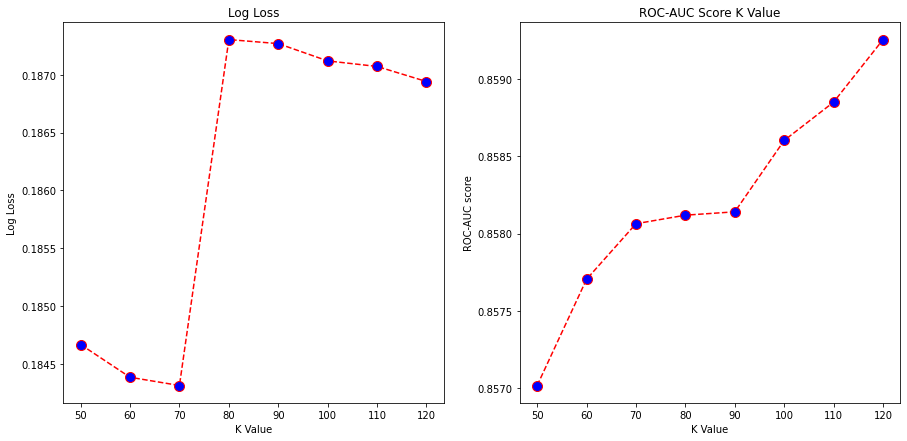

In [13]:
logg = []
roc = []
for i in range(50, 130, 10):
    gbr_params = {'n_estimators': i,
          'max_depth': 4,
          'min_samples_split': 7,
          'learning_rate': 0.1,
          'loss': 'ls'
             }
    gbr = GradientBoostingRegressor(**gbr_params)
    gbr.fit(x_training_data, y_training_data)
    rrr = gbr.predict(x_test_data)
    logg.append(log_loss(y_test_data, rrr))
    roc.append(roc_auc_score(y_test_data, rrr))

    print(i, 'log_loss', log_loss(y_test_data, gbr.predict(x_test_data)))
    print('Roc-Auc score:', roc_auc_score(y_test_data, gbr.predict(x_test_data)))
    print('------------------------------------')
print('min log_loss =', min(logg), 'and it is with n_estimators  =', range(50,130,10)[np.argmin(logg)])
print('max ROC-AUC =', max(roc), 'and it is with n_estimators  =', range(50,130,10)[np.argmax(roc)])
print('------------------------------------')
figure, (axis1, axis2) = plt.subplots(1, 2)
figure.set_figheight(7)
figure.set_figwidth(15)
axis1.plot(range(50,130,10), logg, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10);
axis1.set_title('Log Loss')
axis1.set_xlabel('K Value')
axis1.set_ylabel('Log Loss')
axis2.plot(range(50,130,10), roc, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10);
axis2.set_title('ROC-AUC Score K Value')
axis2.set_xlabel('K Value')
axis2.set_ylabel('ROC-AUC score');


### Нахождение оптимального max_depth

1 log_loss 0.18547438443034722
Roc-Auc score: 0.85539824024282
------------------------------------
2 log_loss 0.1899588164775041
Roc-Auc score: 0.8587051271968913
------------------------------------
3 log_loss 0.18978518957294904
Roc-Auc score: 0.8591802994931952
------------------------------------
4 log_loss 0.18694005919081186
Roc-Auc score: 0.8592630399669663
------------------------------------
5 log_loss 0.1841742726401633
Roc-Auc score: 0.8576448197340714
------------------------------------
min log_loss = 0.1841742726401633 and it is with max_depth  = 5
max ROC-AUC = 0.8592630399669663 and it is with max_depth  = 4
------------------------------------


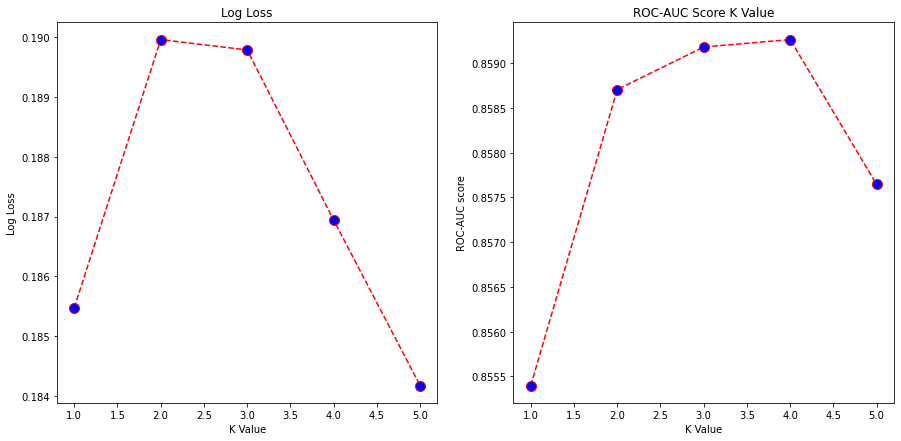

In [14]:
logg = []
roc = []
for i in range(1, 6):
    gbr_params = {'n_estimators': 120,
          'max_depth': i,
          'min_samples_split': 7,
          'learning_rate': 0.1,
          'loss': 'ls'
             }
    gbr = GradientBoostingRegressor(**gbr_params)
    gbr.fit(x_training_data, y_training_data)
    rrr = gbr.predict(x_test_data)
    logg.append(log_loss(y_test_data, rrr))
    roc.append(roc_auc_score(y_test_data, rrr))


    print(i, 'log_loss', log_loss(y_test_data, gbr.predict(x_test_data)))
    print('Roc-Auc score:', roc_auc_score(y_test_data, gbr.predict(x_test_data)))
    print('------------------------------------')
print('min log_loss =', min(logg), 'and it is with max_depth  =', range(1,6)[np.argmin(logg)])
print('max ROC-AUC =', max(roc), 'and it is with max_depth  =', range(1,6)[np.argmax(roc)])
print('------------------------------------')
figure, (axis1, axis2) = plt.subplots(1, 2)
figure.set_figheight(7)
figure.set_figwidth(15)
axis1.plot(range(1,6), logg, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10);
axis1.set_title('Log Loss')
axis1.set_xlabel('K Value')
axis1.set_ylabel('Log Loss')
axis2.plot(range(1,6), roc, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10);
axis2.set_title('ROC-AUC Score K Value')
axis2.set_xlabel('K Value')
axis2.set_ylabel('ROC-AUC score');

### Нахождение оптимального min_samples_split

2 log_loss 0.18701215853407083
Roc-Auc score: 0.8593266564633093
------------------------------------
3 log_loss 0.18696204257270244
Roc-Auc score: 0.8588283597657274
------------------------------------
4 log_loss 0.18719191938596105
Roc-Auc score: 0.858596140039813
------------------------------------
5 log_loss 0.18741214782047202
Roc-Auc score: 0.8581725829683028
------------------------------------
6 log_loss 0.18705126831553168
Roc-Auc score: 0.8592671379621293
------------------------------------
7 log_loss 0.18695004395167156
Roc-Auc score: 0.8592630399669663
------------------------------------
8 log_loss 0.19012468301121033
Roc-Auc score: 0.8589764730194829
------------------------------------
9 log_loss 0.18731081890202622
Roc-Auc score: 0.8584889091663761
------------------------------------
min log_loss = 0.18695004395167156 and it is with min_samples_split  = 7
max ROC-AUC = 0.8593266564633093 and it is with min_samples_split  = 2
------------------------------------


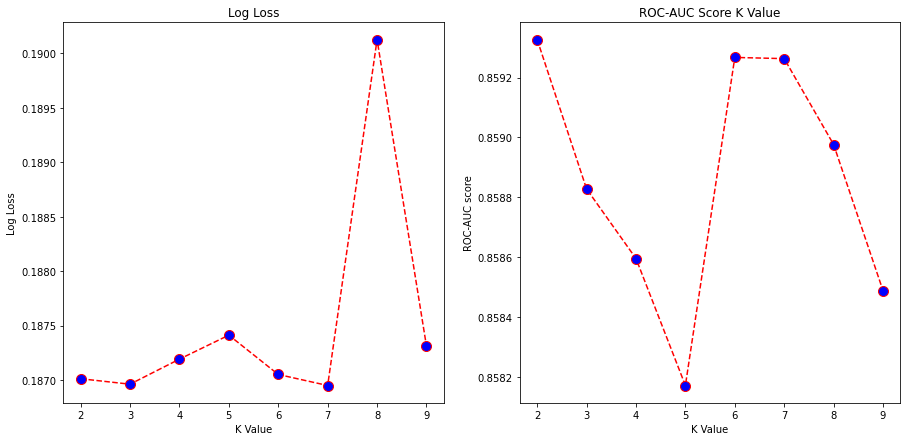

In [15]:
logg = []
roc = []
for i in range(2, 10):
    gbr_params = {'n_estimators': 120,
          'max_depth': 4,
          'min_samples_split': i,
          'learning_rate': 0.1,
          'loss': 'ls'
             }
    gbr = GradientBoostingRegressor(**gbr_params)
    gbr.fit(x_training_data, y_training_data)
    rrr = gbr.predict(x_test_data)
    logg.append(log_loss(y_test_data, rrr))
    roc.append(roc_auc_score(y_test_data, rrr))
    print(i, 'log_loss', log_loss(y_test_data, gbr.predict(x_test_data)))
    print('Roc-Auc score:', roc_auc_score(y_test_data, gbr.predict(x_test_data)))
    print('------------------------------------')
print('min log_loss =', min(logg), 'and it is with min_samples_split  =', range(2,11)[np.argmin(logg)])
print('max ROC-AUC =', max(roc), 'and it is with min_samples_split  =', range(2,11)[np.argmax(roc)])
print('------------------------------------')
figure, (axis1, axis2) = plt.subplots(1, 2)
figure.set_figheight(7)
figure.set_figwidth(15)
axis1.plot(range(2,10), logg, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10);
axis1.set_title('Log Loss')
axis1.set_xlabel('K Value')
axis1.set_ylabel('Log Loss')
axis2.plot(range(2,10), roc, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10);
axis2.set_title('ROC-AUC Score K Value')
axis2.set_xlabel('K Value')
axis2.set_ylabel('ROC-AUC score');

### Классификация с помощью градиентного бустинга

In [16]:
clas_models.append('Gradient Boosting Classification')
gbr_params = {'n_estimators': 100,
          'max_depth': 3,
          'min_samples_split': 5,
          'learning_rate': 0.1
             }
gbr = GradientBoostingClassifier(**gbr_params)
gbr.fit(x_training_data, y_training_data)
preds = gbr.predict(x_test_data)
mse = mean_squared_error(y_test_data, preds)
print('mse: %.3f' % mse)
print("Model Accuracy: %.3f" % gbr.score(x_test_data, y_test_data))
auc_scores.append(roc_auc_score(y_test_data, preds))
f1_scores.append(f1_score(y_test_data, preds))
precisions.append(precision_score(y_test_data, preds))
recalls.append(recall_score(y_test_data, preds))
df = pd.DataFrame()
df['index'] = y_sample['index']
df['target'] = gbr.predict(test)
df

mse: 0.066
Model Accuracy: 0.934


,index,target
0,143522,0
1,116747,0
2,66075,0
3,133292,0
4,83134,0
...,...,...
38871,44475,0
38872,103189,0
38873,48732,0
38874,135410,0


## Модель линейной регрессии

In [17]:
models.append('Linear Regression')

mod = LinearRegression()
mod.fit(x_training_data, y_training_data)
preds = mod.predict(x_test_data)

print("Model Accuracy: %.3f" % mod.score(x_test_data, y_test_data))
mse = mean_squared_error(y_test_data, preds)
print('mse: %.3f' % mse)
print('log_loss: %.3f' % log_loss(y_test_data, preds))
print('Roc-Auc score:', roc_auc_score(y_test_data, preds))
auc_scores.append(roc_auc_score(y_test_data, preds))
log_losses.append(log_loss(y_test_data, preds))
df = pd.DataFrame()
df['index'] = y_sample['index']
df['target'] = mod.predict(test)
df


Model Accuracy: 0.153
mse: 0.054
log_loss: 0.210
Roc-Auc score: 0.8046257388831635


,index,target
0,143522,0.012488
1,116747,-0.001252
2,66075,0.119950
3,133292,0.061350
4,83134,0.043528
...,...,...
38871,44475,0.049174
38872,103189,0.008209
38873,48732,0.016229
38874,135410,0.036987


## Модель ближайших соседей - классификация

In [18]:
clas_models.append('kNN Classification')
model = KNeighborsClassifier(n_neighbors = 4)
model.fit(x_training_data, y_training_data)
print(classification_report(y_test_data, model.predict(x_test_data)))
print("Model Accuracy: %.3f" % model.score(x_test_data, y_test_data))
preds = model.predict(x_test_data)
mse = mean_squared_error(y_test_data, preds)
print('mse: %.3f' % mse)
print('log_loss: %.3f' % log_loss(y_test_data, preds))
f1_scores.append(f1_score(y_test_data, preds))
rauc_scores.append(roc_auc_score(y_test_data, preds))
precisions.append(precision_score(y_test_data, preds))
recalls.append(recall_score(y_test_data, preds))
df = pd.DataFrame()
df['index'] = y_sample['index']
df['target'] = model.predict(test)
df


              precision    recall  f1-score   support

           0       0.94      0.99      0.96      8387
           1       0.50      0.15      0.23       611

    accuracy                           0.93      8998
   macro avg       0.72      0.57      0.60      8998
weighted avg       0.91      0.93      0.91      8998

Model Accuracy: 0.932
mse: 0.068
log_loss: 2.341


,index,target
0,143522,0
1,116747,0
2,66075,0
3,133292,0
4,83134,0
...,...,...
38871,44475,0
38872,103189,0
38873,48732,0
38874,135410,0


### подбор количества ближайших соседей в классификации

min error = 0.0678 and it is with k = 4


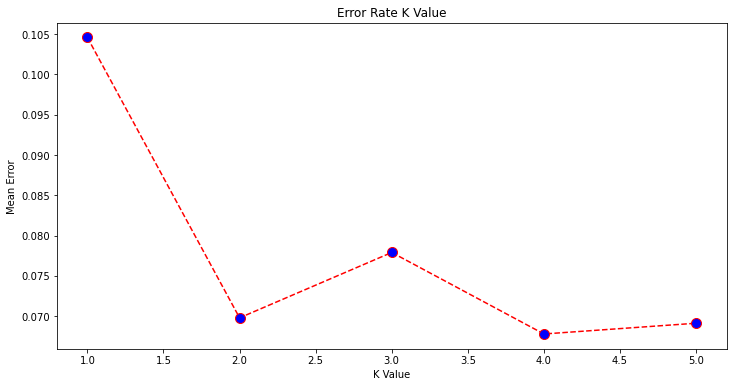

In [19]:
error = []
for i in range(1,6):
    model = KNeighborsClassifier(n_neighbors = i)
    model.fit(x_training_data, y_training_data)
    knn = model.predict(x_test_data)
    error.append(np.mean(knn != y_test_data))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 6), error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10);
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
print('min error =', np.round(min(error), decimals = 4), 'and it is with k =', np.argmin(error)+1)

### Регрессия методом ближайших соседей

In [20]:
models.append('KNN Regression')
modelr = KNeighborsRegressor(n_neighbors = 40)
modelr.fit(x_training_data, y_training_data)
preds = modelr.predict(x_test_data)
#print(classification_report(y_test_data, preds))
print("Model Accuracy: %.3f" % modelr.score(x_test_data, y_test_data))
mse = mean_squared_error(y_test_data, preds)
print('mse: %.3f' % mse)
print('log_loss: %.3f' % log_loss(y_test_data, preds))
auc_scores.append(roc_auc_score(y_test_data, preds))
log_losses.append(log_loss(y_test_data, preds))
df = pd.DataFrame()
df['index'] = y_sample['index']
df['target'] = modelr.predict(test)
df

Model Accuracy: 0.157
mse: 0.053
log_loss: 0.396


,index,target
0,143522,0.000
1,116747,0.000
2,66075,0.125
3,133292,0.100
4,83134,0.025
...,...,...
38871,44475,0.050
38872,103189,0.025
38873,48732,0.025
38874,135410,0.025


### Подбор лучшего числа ближайших соседей

min log_loss = 0.3992 and it is with k = 18


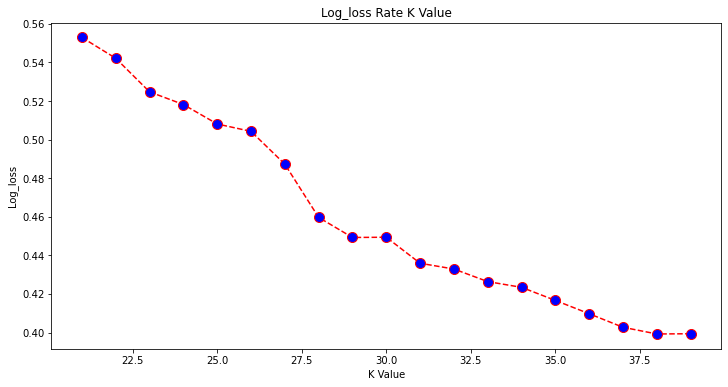

In [21]:
log = []
for i in range(21,40):
    modelr = KNeighborsRegressor(n_neighbors = i)
    modelr.fit(x_training_data, y_training_data)
    rrr = modelr.predict(x_test_data)
    log.append(log_loss(y_test_data, rrr))
plt.figure(figsize=(12, 6))
plt.plot(range(21, 40), log, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10);
plt.title('Log_loss Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Log_loss')
print('min log_loss =', np.round(min(log), decimals = 4), 'and it is with k =', np.argmin(log)+1)

## Дерево решений

In [22]:
clas_models.append('Decision Tree Classification')
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_training_data, y_training_data)
print("Model Accuracy: %.3f" % clf.score(x_test_data, y_test_data))
preds = clf.predict(x_test_data)
print(classification_report(y_test_data, preds))
mse = mean_squared_error(y_test_data, preds)
print('mse: %.3f' % mse)
print('log_loss: %.3f' % log_loss(y_test_data, preds))
f1_scores.append(f1_score(y_test_data, preds))
rauc_scores.append(roc_auc_score(y_test_data, preds))
precisions.append(precision_score(y_test_data, preds))
recalls.append(recall_score(y_test_data, preds))
df = pd.DataFrame()
df['index'] = y_sample['index']
df['target'] = clf.predict(test)
df

Model Accuracy: 0.893
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      8387
           1       0.25      0.29      0.27       611

    accuracy                           0.89      8998
   macro avg       0.60      0.61      0.60      8998
weighted avg       0.90      0.89      0.90      8998

mse: 0.107
log_loss: 3.697


,index,target
0,143522,0
1,116747,0
2,66075,0
3,133292,0
4,83134,0
...,...,...
38871,44475,0
38872,103189,0
38873,48732,0
38874,135410,0


## Логистическая регрессия

In [23]:
models.append('Logistic Regression')
clas_models.append('Logistic Regression')
log = LogisticRegression()
log = log.fit(x_training_data, y_training_data)
print("Model Accuracy: %.3f" % log.score(x_test_data, y_test_data))
preds = log.predict(x_test_data)
print(classification_report(y_test_data, preds))
mse = mean_squared_error(y_test_data, preds)
print('mse: %.3f' % mse)
print('log_loss: %.3f' % log_loss(y_test_data, preds))
log_losses.append(log_loss(y_test_data, preds))
auc_scores.append(roc_auc_score(y_test_data, preds))
f1_scores.append(f1_score(y_test_data, preds))
rauc_scores.append(roc_auc_score(y_test_data, preds))
precisions.append(precision_score(y_test_data, preds))
recalls.append(recall_score(y_test_data, preds))
df = pd.DataFrame()
df['index'] = y_sample['index']
df['target'] = log.predict(test)
df

Model Accuracy: 0.934
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      8387
           1       0.55      0.15      0.23       611

    accuracy                           0.93      8998
   macro avg       0.74      0.57      0.60      8998
weighted avg       0.91      0.93      0.92      8998

mse: 0.066
log_loss: 2.288


,index,target
0,143522,0
1,116747,0
2,66075,0
3,133292,0
4,83134,0
...,...,...
38871,44475,0
38872,103189,0
38873,48732,0
38874,135410,0


## Случайный лес - классификация

In [47]:
clas_models.append('Random Forest Classification')
rnd = RandomForestClassifier(n_estimators = 100)
rnd = rnd.fit(x_training_data, y_training_data)
print("Model Accuracy: %.3f" % rnd.score(x_test_data, y_test_data))
preds = rnd.predict(x_test_data)
print(classification_report(y_test_data, preds))
mse = mean_squared_error(y_test_data, preds)
print('mse: %.3f' % mse)
print('log_loss: %.3f' % log_loss(y_test_data, preds))
f1_scores.append(f1_score(y_test_data, preds))
rauc_scores.append(roc_auc_score(y_test_data, preds))
precisions.append(precision_score(y_test_data, preds))
recalls.append(recall_score(y_test_data, preds))
df = pd.DataFrame()
df['index'] = y_sample['index']
df['target'] = rnd.predict(test)
df

Model Accuracy: 0.934
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      8387
           1       0.55      0.17      0.26       611

    accuracy                           0.93      8998
   macro avg       0.75      0.58      0.61      8998
weighted avg       0.92      0.93      0.92      8998

mse: 0.066
log_loss: 2.272


,index,target
0,143522,0
1,116747,0
2,66075,0
3,133292,0
4,83134,0
...,...,...
38871,44475,0
38872,103189,0
38873,48732,0
38874,135410,0


### Подбор числа деревьев решений в классификации

max ROC-AUC = 0.5862279652263644 and it is with n = 100


Text(0, 0.5, 'ROC-AUC')

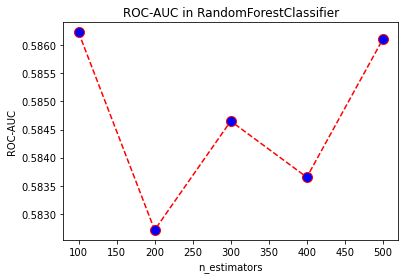

In [48]:
b = []
for i in range(100, 600, 100):
    rnd = RandomForestClassifier(n_estimators = i)
    rnd = rnd.fit(x_training_data, y_training_data)
    b.append(roc_auc_score(y_test_data, rnd.predict(x_test_data)))
print('max ROC-AUC =', max(b), 'and it is with n =', range(100,600,100)[np.argmax(b)])
plt.plot(range(100, 600,100), b, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10);
plt.title('ROC-AUC in RandomForestClassifier')
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC');

### Регрессия с использованием случайного леса

In [27]:
models.append('Random Forest Regression')
rndr = RandomForestRegressor(n_estimators = 400)
rndr = rndr.fit(x_training_data, y_training_data)
print("Model Accuracy: %.3f" % rndr.score(x_test_data, y_test_data))
preds = rndr.predict(x_test_data)
mse = mean_squared_error(y_test_data, preds)
print('mse: %.3f' % mse)
print('log_loss: %.3f' % log_loss(y_test_data, preds))
rauc_scores.append(roc_auc_score(y_test_data, preds))

log_losses.append(log_loss(y_test_data,preds))
df = pd.DataFrame()
df['index'] = y_sample['index']
df['target'] = rndr.predict(test)
df

Model Accuracy: 0.157
mse: 0.053
log_loss: 0.285


,index,target
0,143522,0.00
1,116747,0.04
2,66075,0.11
3,133292,0.02
4,83134,0.01
...,...,...
38871,44475,0.06
38872,103189,0.00
38873,48732,0.02
38874,135410,0.00


### Подбор числа деревьев решений в регрессии

100 log_loss: 0.31347185059303634
200 log_loss: 0.26554377451239775
300 log_loss: 0.2522793681885313
400 log_loss: 0.242184480420152
500 log_loss: 0.24614387359433051
min log_loss = 0.242184480420152 and it is with k = 400


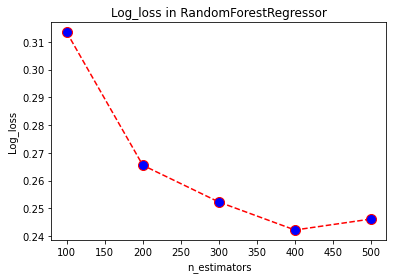

In [49]:
a = []
for i in range(100, 600, 100):
    rnd = RandomForestRegressor(n_estimators = i)
    rnd = rnd.fit(x_training_data, y_training_data)
    log = log_loss(y_test_data, rnd.predict(x_test_data))
    print(i, 'log_loss:', log)
    a.append(log)
print('min log_loss =', min(a), 'and it is with k =', range(100,600,100)[np.argmin(a)])
plt.plot(range(100, 600,100), a, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10);
plt.title('Log_loss in RandomForestRegressor')
plt.xlabel('n_estimators')
plt.ylabel('Log_loss');

## Измерение точности регрессионных моделей

In [30]:
scores = pd.DataFrame()
scores['Model'] = models
scores['Log Losses'] = log_losses
scores['ROC-AUC'] = auc_scores
scores.set_index('Model')

,Log Losses,ROC-AUC
Model,,
Gradient Boosting,0.184071,0.858130
Linear Regression,0.209572,0.578923
KNN Regression,0.395749,0.804626
Logistic Regression,2.287749,0.788757
Random Forest Regression,0.284734,0.568420


## Метрики для классификационных моделей

In [31]:
clas_scores = pd.DataFrame()
clas_scores['Model'] = clas_models
clas_scores['F1 scores'] = f1_scores
clas_scores['ROC-AUC'] = rauc_scores
clas_scores['Precision'] = precisions
clas_scores['Recall'] = recalls
clas_scores.set_index('Model')

,F1 scores,ROC-AUC,Precision,Recall
Model,,,,
Gradient Boosting Classification,0.256219,0.567585,0.533679,0.168576
kNN Classification,0.225888,0.612549,0.502825,0.145663
Decision Tree Classification,0.267681,0.568420,0.250000,0.288052
Logistic Regression,0.229974,0.592953,0.546012,0.145663
Random Forest Classification,0.293040,0.833716,0.576923,0.196399
